In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter

import warnings
warnings.filterwarnings("ignore")

from SyntheticDataModule import *
from estimators import *
from utils import *

Study index S: 0
Sample size n: 5000
Covariate dimensionality: 1
***
True ATE: 1.089
Imputed ATE estimate: 0.956
Censoring-dropped ATE estimate: 0.961
***
Oracle IPW-estimated ATE: 1.140

Study index S: 1
Sample size n: 25000
Covariate dimensionality: 1
***
True ATE: 0.995
Imputed ATE estimate: 0.767
Censoring-dropped ATE estimate: 0.786
***
Oracle IPW-estimated ATE: 1.007



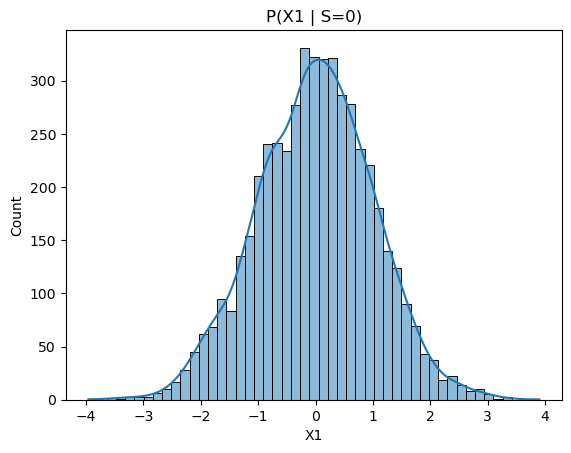

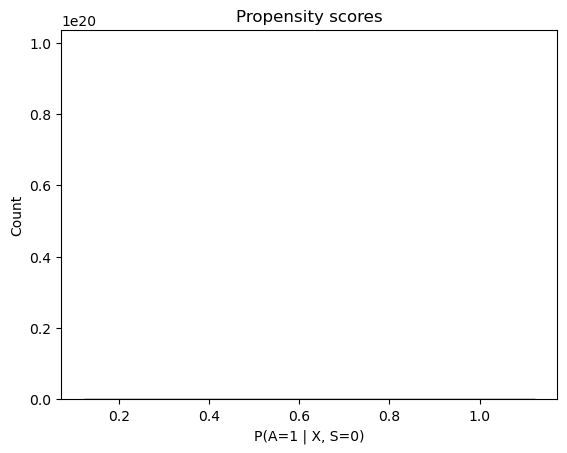

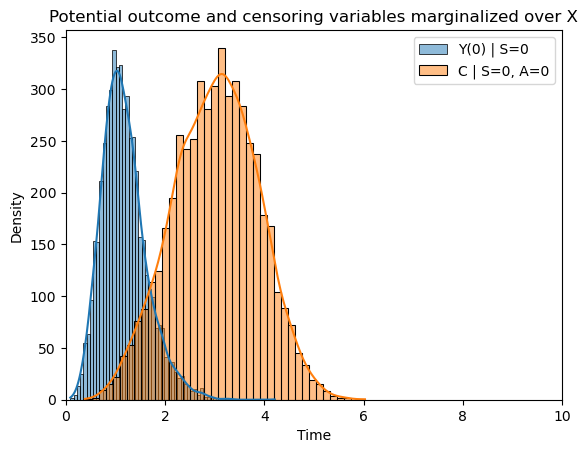

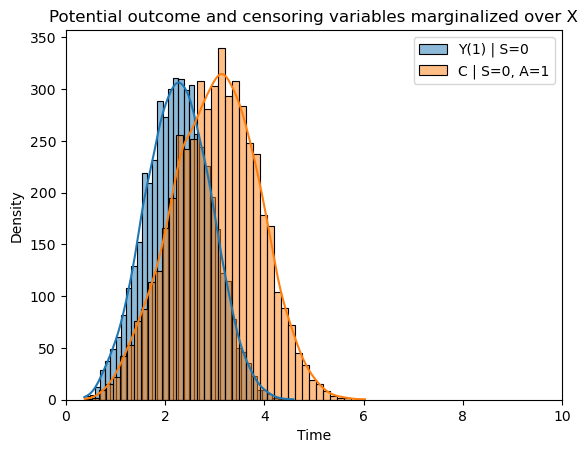

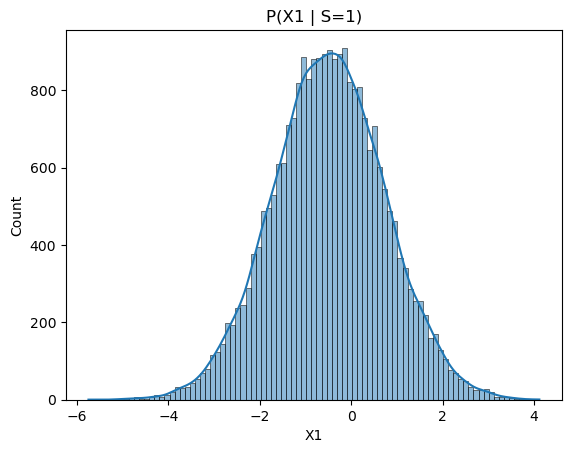

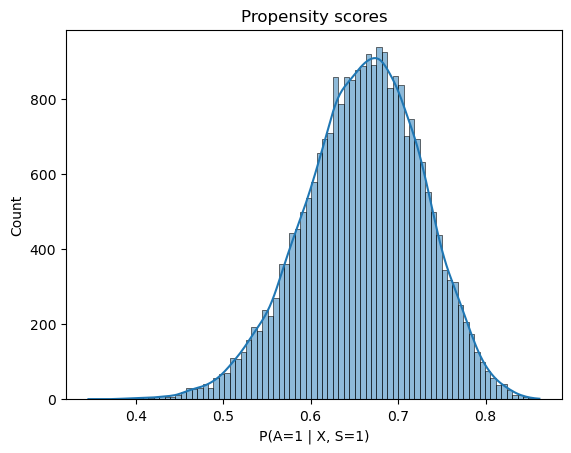

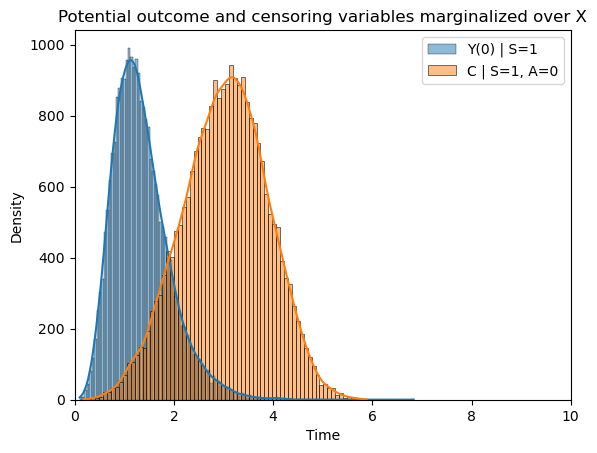

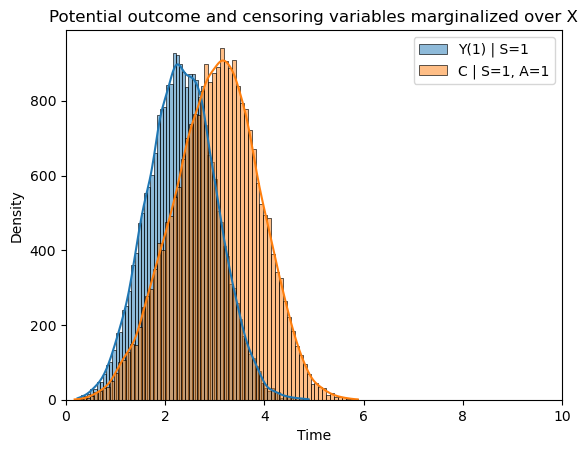

In [2]:
rct_size = 5000
m = 3
obs_size = rct_size * m

RCTData = SyntheticDataModule(d=1, save_df=True, n=rct_size, S=0,
                                px_dist='Gaussian', px_args={'mean': [0], 'cov': [[1]]},
                                prop_fn='sigmoid', prop_args={'beta': [0.5, 0]},
                                hazard_fn='weibull', cox_args={'A0': {'beta': [0,1], 'lambda': 0.8, 'p': 4},
                                                            'A1': {'beta': [0,.25], 'lambda': 0.4, 'p': 4},
                                                            'cen_A0': {'beta': [0,0], 'lambda': 0.3, 'p': 4},
                                                            'cen_A1': {'beta': [0,0], 'lambda': 0.3, 'p': 4},},)

df_rct_oracle, df_rct = RCTData.get_df()
RCTData.summary()

OBSData = SyntheticDataModule(d=1, save_df=True, n=obs_size, S=1,
                                px_dist='Gaussian', px_args={'mean': [-0.5], 'cov': [[1.5]]},
                                prop_fn='sigmoid', prop_args={'beta': [0.8, 0.25]},
                                hazard_fn='weibull', cox_args={'A0': {'beta': [0,1], 'lambda': 0.8, 'p': 4},
                                                                'A1': {'beta': [0,.25], 'lambda': 0.4, 'p': 4},
                                                                'cen_A0': {'beta': [0,0], 'lambda': 0.3, 'p': 4},
                                                                'cen_A1': {'beta': [0,0], 'lambda': 0.3, 'p': 4},},)

df_obs_oracle, df_obs = OBSData.get_df()
OBSData.summary()

df_combined = pd.concat([df_rct, df_obs], axis=0)

In [4]:
df_combined['P(S_X)'], _, _ = prop_score_est(df_combined, 'S', RCTData.cov_list, 'logistic')

df_combined.loc[df_combined.S==0, 'P(A_XS)'], full_x_s0, full_pa_x_s0 = prop_score_est(df_combined.query('S==0'), 'A', RCTData.cov_list, 'mean', get_full_fn=True, interval=[-10,10])
df_combined.loc[df_combined.S==1, 'P(A_XS)'], full_x_s1, full_pa_x_s1 = prop_score_est(df_combined.query('S==1'), 'A', OBSData.cov_list, 'logistic', get_full_fn=True, interval=[-10,10])

Optimization terminated successfully.
         Current function value: 0.439079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632768
         Iterations 5


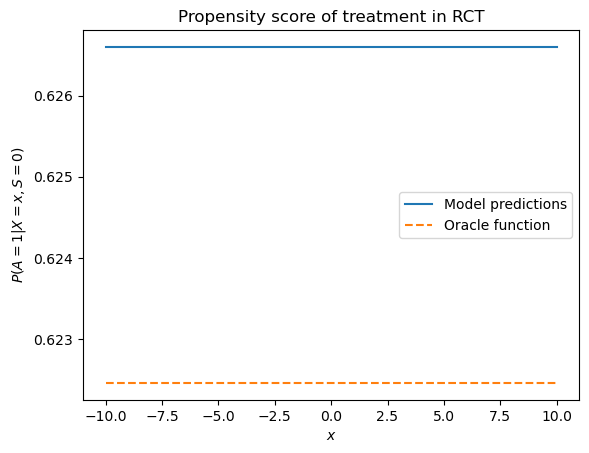

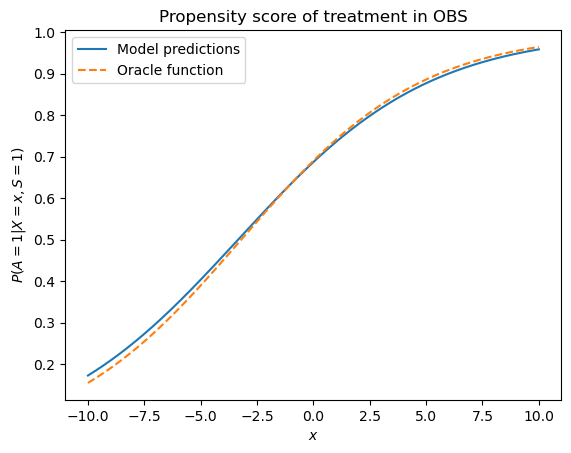

In [6]:
plt.figure()
plt.plot(full_x_s0, full_pa_x_s0, label='Model predictions')
plt.plot(full_x_s0, RCTData.calc_px(sm.add_constant(full_x_s0)), label='Oracle function', ls='--')
plt.title('Propensity score of treatment in RCT')
plt.xlabel(r'$x$')
plt.ylabel(r'$P(A=1 | X=x, S=0)$')
plt.legend()
plt.show()

plt.figure()
plt.plot(full_x_s1, full_pa_x_s1, label='Model predictions')
plt.plot(full_x_s0, OBSData.calc_px(sm.add_constant(full_x_s1)), label='Oracle function', ls='--')
plt.title('Propensity score of treatment in OBS')
plt.xlabel(r'$x$')
plt.ylabel(r'$P(A=1 | X=x, S=1)$')
plt.legend()
plt.show()
